# Gradient vector flow

https://en.wikipedia.org/wiki/Gradient_vector_flow

Gradient vector flow has been used to segment touching nuclei in 
https://pubmed.ncbi.nlm.nih.gov/18638189/

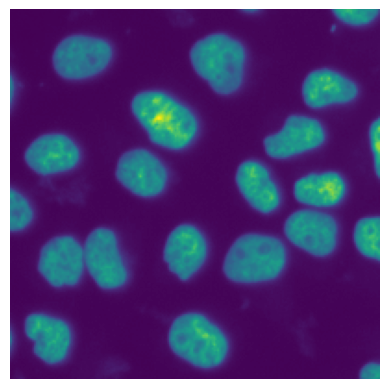

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
image = io.imread('../data/nuclei.tif')[:200,:200]
plt.imshow(image)
plt.axis('off');

We define functions for visualizing flows

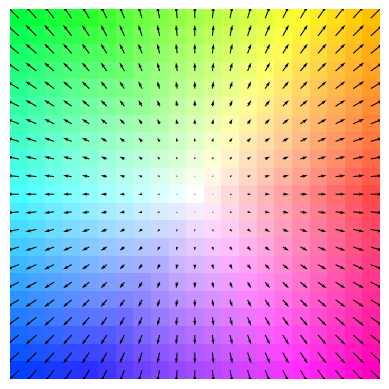

In [2]:
from skimage.color import hsv2rgb
from math import pi

def flow2rgb(flow):    
    '''Convert 2D vector flow into a HSV code'''
    s = np.sqrt(np.sum(np.square(flow), axis=0))
    s = s / s.max()    
    h = ( 2*pi - np.arctan2(flow[0], flow[1])) / (2*pi)
    v = 255 * np.ones_like(s)    
    return hsv2rgb(np.stack([h,s,v],axis=2)).astype(np.uint8)

def show_flow(v, stride=5, color='k'):
    '''Display the flow as HSV and quiver'''
    plt.imshow(flow2rgb(v))
    x,y = np.meshgrid(np.arange(v.shape[2]), np.arange(v.shape[1]))
    plt.quiver(x[::stride,::stride],y[::stride,::stride],v[1,::stride,::stride],-v[0,::stride,::stride],color=color)
    plt.axis('off')

show_flow(np.roll(np.stack(np.meshgrid(np.r_[-10:11],np.r_[-10:11])),shift=1,axis=0),1)


We compute now the gradient vector flow on the image

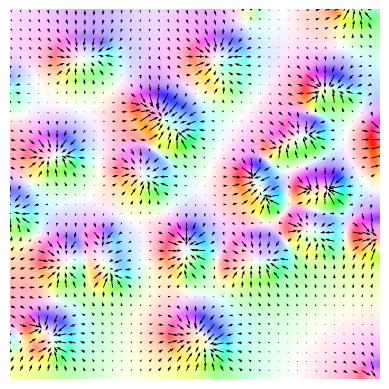

In [3]:
from scipy import ndimage

def gradient_vector_flow(image, alpha=1, mu=1, prefilter=1):
    '''Compute the gradient vector flow using an iterative scheme for solving the PDE'''
    f = np.stack(np.gradient(ndimage.gaussian_filter(image.astype(float), prefilter)))
    q = np.sum(np.square(f), axis=0)
    #q = smoothness * q / q.max()
    q[q<0.5*q.mean()] = 0
    q[q>0] = 1
    v = f
    for _ in range(500):
        dv = alpha*np.stack([ndimage.laplace(x) for x in v]) + (alpha+mu) *np.stack(np.gradient(np.gradient(v[0],axis=0) + np.gradient(v[1],axis=1))) + q * (f - v)
        v = v + dv / np.abs(dv).max()
    return v

flow = gradient_vector_flow(image, 1, 1, 2)
show_flow(flow)


Trace back the flow starting from each pixel in the image

In [4]:
from numba import jit

@jit(nopython=True)
def solve_streamline(v,x0):
    x = x0.astype(np.int64)
    dx0 = np.zeros(x.shape)
    dx1 = np.zeros(x.shape)
    for _ in range(500):        
        n = np.sqrt( v[0,x[0],x[1]]**2 + v[1,x[0],x[1]]**2 )        
        dx1[0] = v[0,x[0],x[1]] / n
        dx1[1] = v[1,x[0],x[1]] / n         
        x[0] = x[0] + round(dx1[0])
        x[1] = x[1] + round(dx1[1])
        a = np.arccos(np.dot(dx0,dx1))
        if a > pi/2:
            break
        dx0 = dx1
        x = np.maximum(1,np.minimum(np.array(v[0].shape)-1, x))
    return x

@jit(nopython=True,parallel=True)
def backtrace_loop(v,X,Y):
    endpoints = np.zeros(v.shape, dtype=np.int64)
    for xs,ys in zip(X.ravel(), Y.ravel()):    
        endpoints[:,ys,xs] = solve_streamline(v, np.array([ys,xs]))
    return endpoints

def backtrace_flow(v):
    x = np.arange(v.shape[2])
    y = np.arange(v.shape[1])
    X, Y = np.meshgrid(x,y)    
    return backtrace_loop(v,X,Y)
    #endpoints = np.zeros(v.shape, dtype=np.int64)
    #for xs,ys in zip(X.ravel(),Y.ravel()):    
    #    endpoints[:,ys,xs] = solve_streamline(v, np.squeeze([ys,xs]))
    #return endpoints



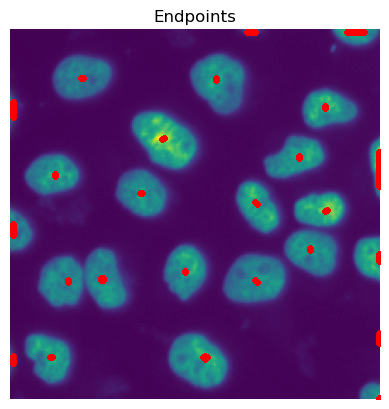

In [5]:
endpoints = backtrace_flow(flow)
plt.imshow(image)
plt.plot(endpoints[1].ravel(),endpoints[0].ravel(),'r.')
plt.title('Endpoints')
plt.axis('off');

Spatially cluster the endpoints to create labels and assign the labels to the 
origin pixels

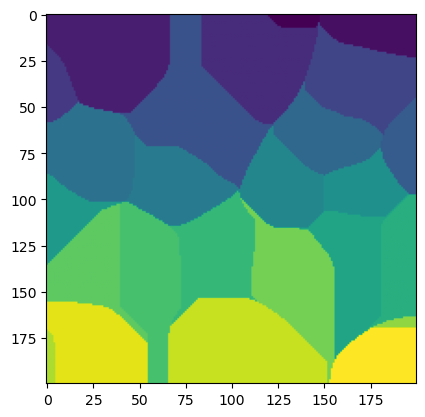

In [7]:
from skimage import measure
area_threshold = 0
h = np.histogram2d(endpoints[0].ravel(), endpoints[1].ravel(), bins=np.array(image.shape), range=[[0,image.shape[0]],[0,image.shape[1]]])[0]
hlabels = measure.label(h > area_threshold)
labels = np.zeros(image.shape)
for k in np.unique(hlabels):
    center = measure.centroid(hlabels==k)
    d = np.sqrt(sum(np.square(x-c) for x,c in zip(endpoints,center)))
    labels[d<10] = k
plt.imshow(labels)

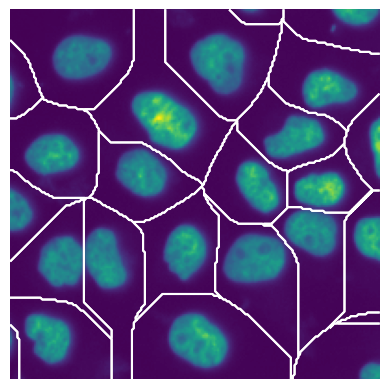

In [8]:

plt.imshow(image)
for k in np.unique(labels):
    contours = measure.find_contours(labels==k)
    for contour in contours:        
        plt.plot(contour[:,1],contour[:,0],'w')
plt.axis('off');


## Vector field convolution

In (Li, B.; Acton, S.T. (2007). "Active contour external force using vector field convolution for image segmentation". IEEE Transactions on Image Processing. 16 (8): 2096–2106.), an convolution approach is proposed to estimate the vector flow.

The idea is to convolve the edge map by a vectorial kernel.

(2, 200, 200)


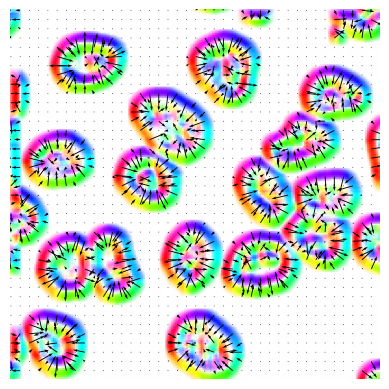

In [10]:
def vector_field_convolution(image, R, smoothing=2):
    f = np.stack(np.gradient(ndimage.gaussian_filter(image,smoothing)))
    f = f / f.max()
    # compute the edge map
    q = np.sum(np.square(f), axis=0)
    q[q<0.5*q.mean()] = 0
    q[q>0] = 1
    #         
    grid = np.meshgrid(np.arange(-R,R+1),np.arange(-R,R+1),indexing='ij')
    kernel = grid[0] + 1j * grid[1]
    v = np.fft.ifft2(np.fft.fft2(kernel, image.shape) * np.fft.fft2(q))#f[0]+1j*f[1]))
    v = -np.stack([v.real,v.imag])    
    return v

v = vector_field_convolution(image, 3, 1)
show_flow(v)
print(v.shape)
